In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
import PIL
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Activation Map 확인하기 위핸 데이터 준비
standford_dogs 데이터 셋 사용
- 120종의 개를 사진이 있음

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteY7N8KR/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteY7N8KR/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


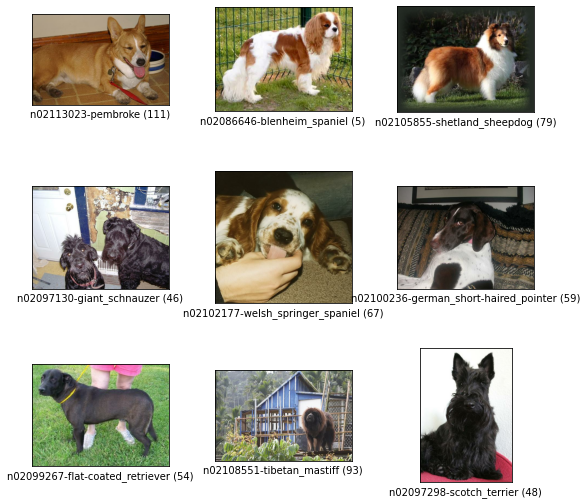

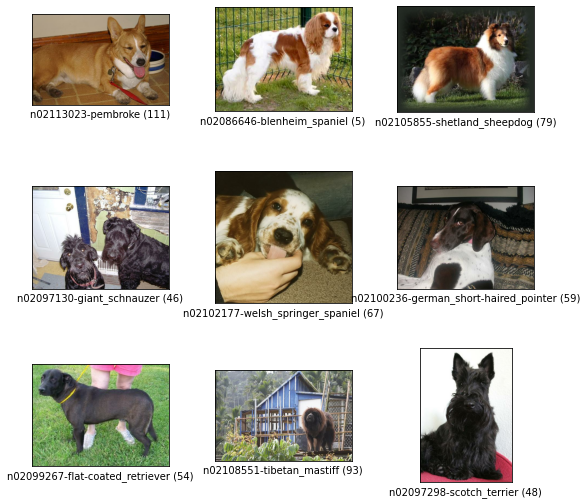

In [5]:
tfds.show_examples(ds_train, ds_info)

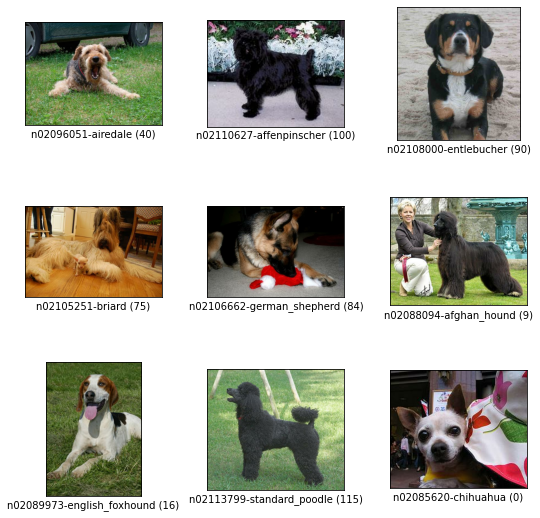

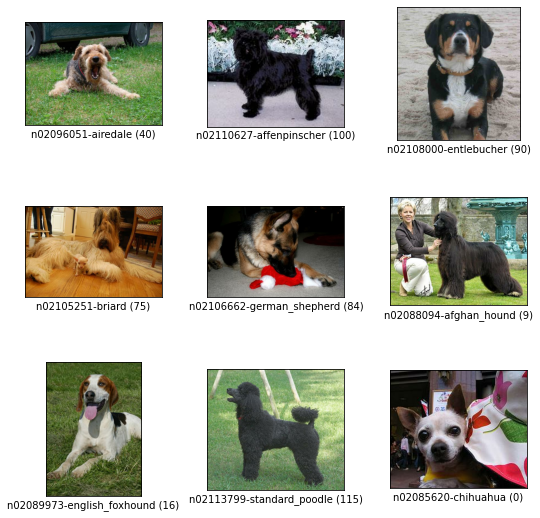

In [6]:
tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### bbox란?
바운딩 박스로 물체의 위치를 사각형 영역으로 표기하는 방법

## CAM 만들기
- 미리 이미지넷(ImageNet)데이터에 훈련된 ResNet50을 기반으로 하고 이후 pooling layer 뒤에 소프트맥스 레이어를 붙이면 Grad-CAM을 만들 수 있음

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
# preds = ADD_YOUR_LAYER(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 2s 0us/step


In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)


(16, 224, 224, 3)
(16,)


In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 114s 127ms/step - loss: 2.2032 - accuracy: 0.4493 - val_loss: 3.0426 - val_accuracy: 0.2677
Epoch 2/2
750/750 [==============================] - 93s 124ms/step - loss: 0.6583 - accuracy: 0.8217 - val_loss: 1.1333 - val_accuracy: 0.6705


In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


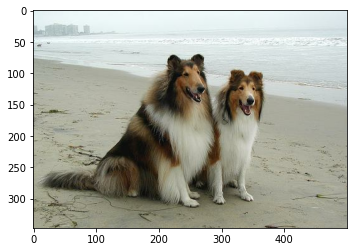

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


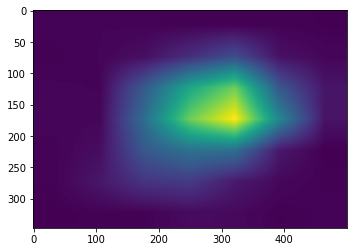

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

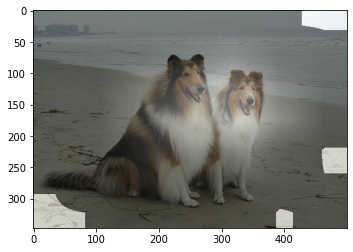

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-CAM 구현

108


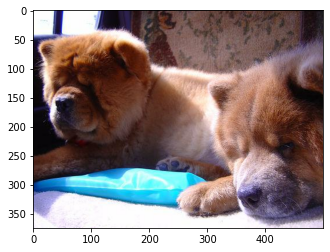

In [60]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

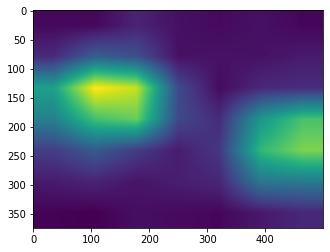

In [61]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

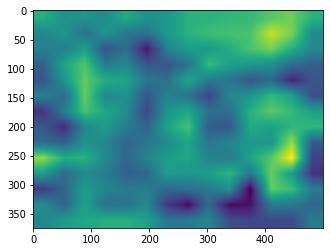

In [62]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

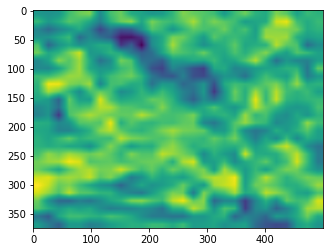

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

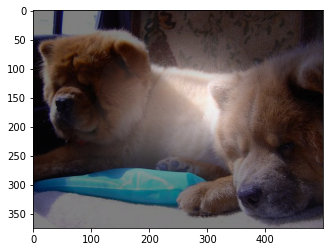

In [64]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 바운딩 박스

In [40]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

#### CAM

40


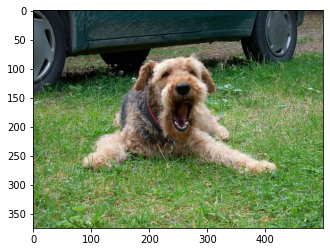

In [52]:
item_cam = get_one(ds_test)
print(item_cam['label'])
plt.imshow(item_cam['image'])
plt.show()

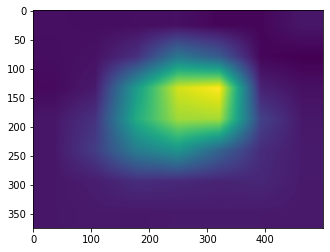

In [53]:
cam_image = generate_cam(cam_model, item_cam)
plt.imshow(cam_image)
plt.show()

In [54]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[ 68, 320],
       [ 49,  49],
       [429,  23],
       [448, 294]])

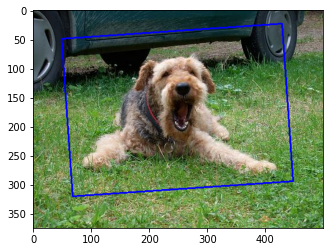

In [55]:
image = copy.deepcopy(item_cam['image'])
image_CamBbox = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_CamBbox)
plt.show()

#### Grad-CAM

108


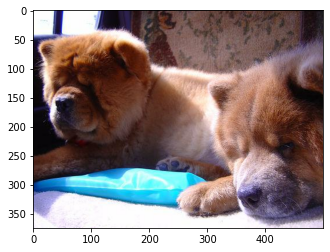

In [38]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

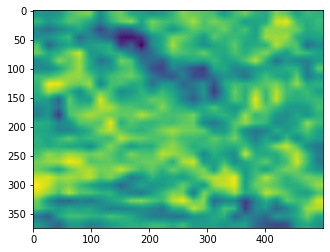

In [65]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

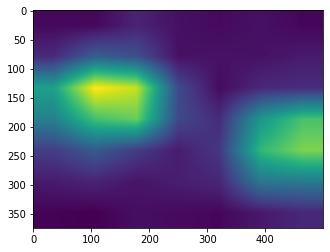

In [69]:
grad_cam_imag2 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_imag2)
plt.show()

In [66]:
rect = get_bbox(cam_image)
rect

array([[ 68, 320],
       [ 49,  49],
       [429,  23],
       [448, 294]])

In [70]:
rect2 = get_bbox(grad_cam_imag2)
rect2

array([[496, 388],
       [-44, 279],
       [ 19, -35],
       [559,  73]])

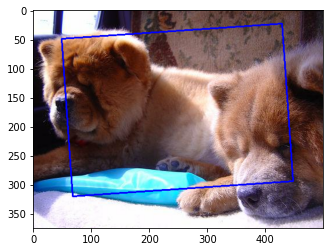

In [67]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

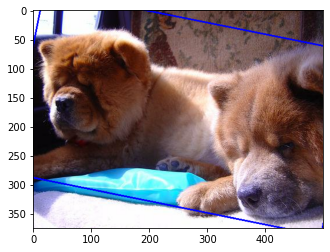

In [71]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# Intersection Over Union (IoU)
- IoU는 두영역의 교집합인 intersection영역의 넓이를 두 영역의 합집합인 union영역으로 나누어준 값
- 찾고자 하는 물건의 절대적인 면적과 상관없이 영역을 정확하게 잘 찾아내는지 상대적인 비율을 구할 수 있음
- 모델이 영역을 잘 찾았는지 비교하는 좋은 지표

In [43]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


예측한 bbox값과 실제 bbox 얼마나 유사한지 IoU계산

In [46]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

#### CAM

In [56]:
pred_bbox = rect_to_minmax(rect_cam, item_cam['image'])
pred_bbox

[0.06133333333333333, 0.098, 0.8533333333333334, 0.896]

In [57]:
item_cam['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [58]:
get_iou(pred_bbox, item_cam['objects']['bbox'][0])

0.6021366244988943

### Grad-CAM

깊은 layer 사용

In [44]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.096, 0.066, 1.0266666666666666, 0.928]

In [45]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [47]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35788904901517343

낮은 layer 사용

In [72]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[-0.09333333333333334, -0.088, 1.0346666666666666, 1.118]

In [73]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.31291531534741085

# 결과 및 회고
CAM의 경우 특성을 추출하는 CNN 네트워크 뒤에 GAP와 소프트맥스가 붙는 형태로 구성되야 하지만 Grad-CAM의 경우 제약이 없다는 장점이 있다.
<br/>
이러한 특성을 활용하여 CAM과 Grad-CAM을 적용한 결과 CAM의 경우 IoU 결과가 0.6으로 나타났으며 Grad-CAM은 0.3으로 좋지 않는 결과가 나타났다.
<br/>
하지만 Grad-CAM에 적용한 이미지의 경우 양 끝으로 강아지가 2마리로 구성되어 있는 이미지로 상대적으로 어려운 이미지가 적용되어 IoU의 결과값이 낮게 나온 것으로 판단된다.
하지만 Grad-CAM에 적용할 때 layer가 조금 더 깊이 있는 layer를 사용하여 본 결과 IoU 결과값이 조금 더 높게 나타났다.
<br/>
즉, layer가 깊을수록 해당 이미지의 특징 정보가 더 많이 가지고 있다는 것을 알 수 있다.
